The codes below are originally created by the lesson and demo at Udacity self-driving car nano degree.

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import random
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib inline

## Section 1: Make a list of images to read in

In [2]:
import os
import glob

# images are divided up into veheicles and non-vehicles folders
# First locate vehicle images
basedir = 'data/vehicles/'

# Deffrerent folders represent different sources for images e.g. GTI, Kitti, etc.
image_types = os.listdir(basedir)
cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))
    
print('Number of Vehicle Images found: ', len(cars))
with open('data/cars.txt', 'w') as f:
    for fn in cars:
        f.write(fn + '\n')
        
# Do the same thing for non-vehicle images
basedir = 'data/non-vehicles/'
image_types = os.listdir(basedir)
notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir + imtype + '/*'))
    
print('Number of Non-Vehicle Images found: ', len(notcars))
with open('data/noncars.txt', 'w') as f:
    for fn in notcars:
        f.write(fn + '\n')

Number of Vehicle Images found:  8792
Number of Non-Vehicle Images found:  8968


## Section 2:  Define functions that are used in the project

In [99]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                    vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 transform_sqrt=False,
                                 visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:
        features = hog(img, orientations=orient,
                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                 cells_per_block=(cell_per_block, cell_per_block),
                                 transform_sqrt=False,
                                 visualise=vis, feature_vector=feature_vec)
        return features
    

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features  
# NEED TO CHANGE bins_range if reading .png files with mping!
def color_hist(img, nbins=32):  # bins_range=None, bins_range=(0, 256)
    # Compute the histogram of the channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins) # , range=bins_range
    channel2_hist = np.histogram(img[:,:,1], bins=nbins) # , range=bins_range
    channel3_hist = np.histogram(img[:,:,2], bins=nbins) # , range=bins_range
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# KEEP IN MIND IF YOU DECIDE TO USE THIS FUNCTION LATER
# IN YOUR PROJECT THAT IF YOU READ THE IMAGE WITH 
# cv2.imread() INSTEAD YOU START WITH BGR COLOR!
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img_file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(img_file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)         
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        # Apply color_hist() to get color histogram features
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins) #, bins_range=hist_range
            file_features.append(hist_features)
        # Apply get_hog_features() to get hog features
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                           orient, pix_per_cell, cell_per_block,
                                                           vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                           pix_per_cell, cell_per_block,
                                                           vis=False, feature_vec=True)
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    x_span = x_start_stop[1] - x_start_stop[0]
    y_span = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((x_span - nx_buffer) / nx_pix_per_step) 
    ny_windows = np.int((y_span - ny_buffer) / ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate each window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=vis, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=vis, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows


# Define a function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles, gray=False):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            cmap = 'hot'
            if gray:
                cmap = 'gray'
            plt.imshow(img, cmap=cmap)
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

## Section 3:  HOG image exploratory analysis

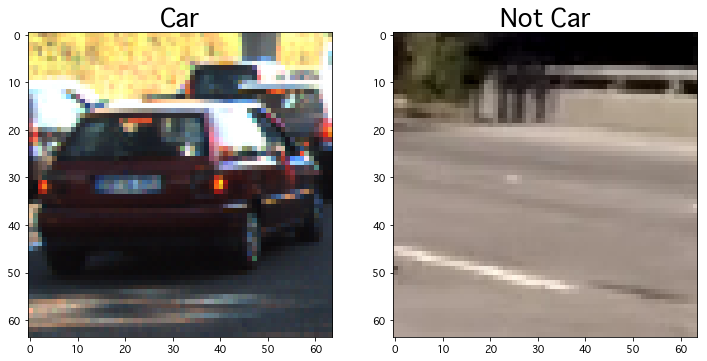

In [151]:
# Choose random car / not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(car_image, aspect=1)
ax1.set_title('Car', fontsize=25)
ax2.imshow(notcar_image, aspect=1)
ax2.set_title('Not Car', fontsize=25)
plt.savefig('output_images/sample_training_images.jpg', bbox_inches='tight')

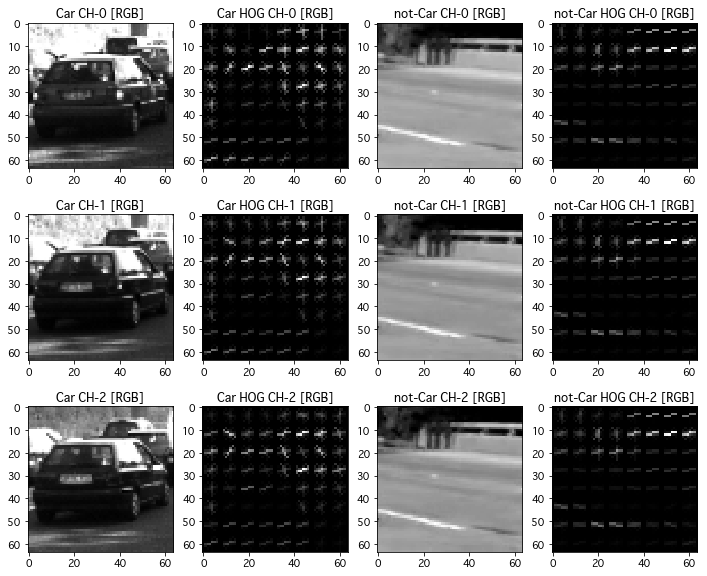

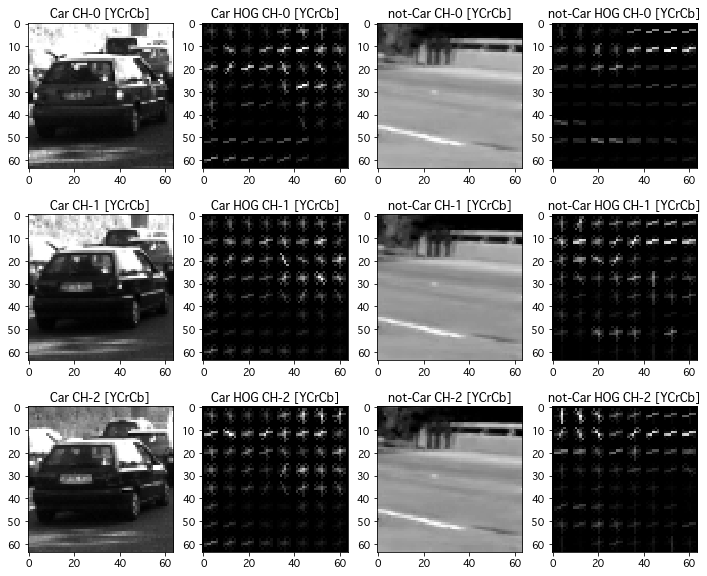

In [153]:
# # Choose random car / not-car indices
# car_ind = np.random.randint(0, len(cars))
# notcar_ind = np.random.randint(0, len(notcars))

# # Read in car / not-car images
# car_image = mpimg.imread(cars[car_ind])
# notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature paramemeters
#color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
#hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

for color_space in ['RGB', 'YCrCb']:
    images = []
    titles = []

    for color_channel in [0, 1, 2]:
        hog_channel = color_channel
        car_features, car_hog_image = single_img_features(car_image, 
                                color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
        images.append(car_image[:,:,color_channel])
        images.append(car_hog_image)
        titles.append('Car CH-' + str(color_channel)  + ' [' + color_space + ']')
        titles.append('Car HOG CH-' + str(color_channel) + ' [' + color_space + ']')

        notcar_features, notcar_hog_image = single_img_features(notcar_image,
                                color_space=color_space, spatial_size=spatial_size,
                                hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
        images.append(notcar_image[:,:,color_channel])
        images.append(notcar_hog_image)
        titles.append('not-Car CH-' + str(color_channel)  + ' [' + color_space + ']')
        titles.append('not-Car HOG CH-' + str(color_channel) + ' [' + color_space + ']')

    fig = plt.figure(figsize=(12, 10))
    visualize(fig, 3, 4, images, titles, gray=True)
    plt.savefig('output_images/hog_images_' + color_space + '.jpg', bbox_inches='tight')

## Section 4:  HOG features parameter tuning and Model selection

In [158]:
# Define feature parameters
#color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
for color_space in ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
    print("Color Space:", color_space)
    orient = 9  # HOG orientations
    pix_per_cell = 8 # HOG pixels per cell
    cell_per_block = 2 # HOG cells per block
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32   # Number of histogram bins
    spatial_feat = True # Spatial features on or off
    hist_feat = True # Histogram features on or off
    hog_feat = True # HOG features on or off

    t = time.time()
    #n_samples = 1000
    #random_idxs = np.random.randint(0, len(cars), n_samples)
    test_cars = cars #np.array(cars)[random_idxs]
    test_notcars = notcars #np.array(notcars)[random_idxs]

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    print(time.time() - t, "Seconds to compute featuers...")

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    # Split up data into randomized training and test sets
    rand_state = 2 # np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.1, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
          'pixels per cell and', cell_per_block,'cells per block',
           hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    print('')

Color Space: RGB
92.51927781105042 Seconds to compute featuers...
Using: 9 orientations 8 pixels per cell and 2 cells per block 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
40.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9837

Color Space: HSV
98.75307297706604 Seconds to compute featuers...
Using: 9 orientations 8 pixels per cell and 2 cells per block 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
41.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9927

Color Space: LUV
88.94736099243164 Seconds to compute featuers...
Using: 9 orientations 8 pixels per cell and 2 cells per block 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
42.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9944

Color Space: HLS
88.68672299385071 Seconds to compute featuers...
Using: 9 orientations 8 pixels per cell and 2 cells per block 32 histogram bins, and (32, 32) spatial sampling
Feature vector length:

In [159]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
#n_samples = 1000
#random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time() - t, "Seconds to compute featuers...")

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = 2 # np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
      'pixels per cell and', cell_per_block,'cells per block',
       hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

141.51393103599548 Seconds to compute featuers...
Using: 9 orientations 8 pixels per cell and 2 cells per block 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
31.64 Seconds to train SVC...
Test Accuracy of SVC =  0.9961


In [166]:
# Define feature parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
#n_samples = 1000
#random_idxs = np.random.randint(0, len(cars), n_samples)
test_cars = cars #np.array(cars)[random_idxs]
test_notcars = notcars #np.array(notcars)[random_idxs]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time() - t, "Seconds to compute featuers...")

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = 2 # np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
      'pixels per cell and', cell_per_block,'cells per block',
       hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))
for name, clf in zip(['LinearSVC', 'Logistic Regression', 'Random Forest'], [LinearSVC(), LogisticRegression(), RandomForestClassifier()]):
    print(''); print(name)
    # Check the training time for the classifier
    t = time.time()
    clf.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train', name)
    # Check the score of the classifier
    print('Test Accuracy = ', round(clf.score(X_test, y_test), 4))
    t3 = time.time()
    print(round(t3 - t2, 2), 'Seconds to test', name)

78.11055183410645 Seconds to compute featuers...
Using: 9 orientations 8 pixels per cell and 2 cells per block 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460

LinearSVC
22.22 Seconds to train LinearSVC
Test Accuracy =  0.9961
0.45 Seconds to test LinearSVC

Logistic Regression
66.27 Seconds to train Logistic Regression
Test Accuracy =  0.9966
0.02 Seconds to test Logistic Regression

Random Forest
42.1 Seconds to train Random Forest
Test Accuracy =  0.9837
0.06 Seconds to test Random Forest


## Section 5: Sliding Window Search

0.0 1.0
0.5351309776306152 seconds to process one image searching 100 windows
0.0 1.0
0.6175742149353027 seconds to process one image searching 100 windows
0.0 1.0
0.647719144821167 seconds to process one image searching 100 windows
0.0 1.0
0.7816638946533203 seconds to process one image searching 100 windows
0.0 1.0
0.6606059074401855 seconds to process one image searching 100 windows
0.0 1.0
0.671597957611084 seconds to process one image searching 100 windows


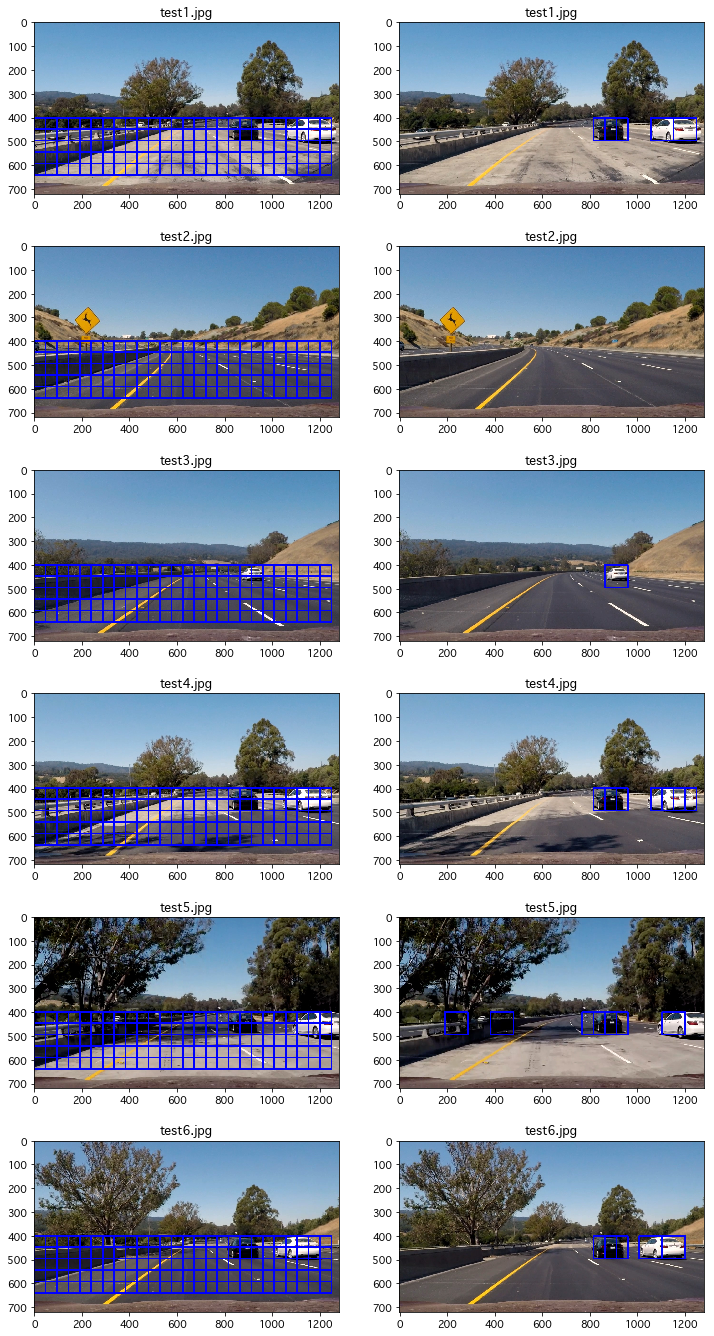

In [192]:
searchpath = 'test_images/*'
example_images = glob.glob(searchpath)

images = []
titles = []
y_start_stop = [400, 656]  # Min and max in y to search in slidide_window()
overlap = 0.5
for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255 # if input image is jpeg we need to scale to 0 to 1 range
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(int(64*1.5), int(64*1.5)), xy_overlap=(overlap, overlap))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_img, windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append(img_src.split('/')[-1])
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append(img_src.split('/')[-1])
    print(time.time() - t1, 'seconds to process one image searching', len(windows), 'windows')

fig = plt.figure(figsize=(12, 24)) #, dpi=300)
visualize(fig, 6, 2, images, titles)
plt.savefig('output_images/sliding_windows.jpg', bbox_inches='tight')

## Section 6: HOG Sub-sampling Sliding Window Search

In [16]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [17]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
    nfeat_per_block = orient * cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
    return draw_img, heatmap

0.4197719097137451 seconds to run
0.46337008476257324 seconds to run
0.5614941120147705 seconds to run
0.3873310089111328 seconds to run
0.541132926940918 seconds to run
0.5416369438171387 seconds to run


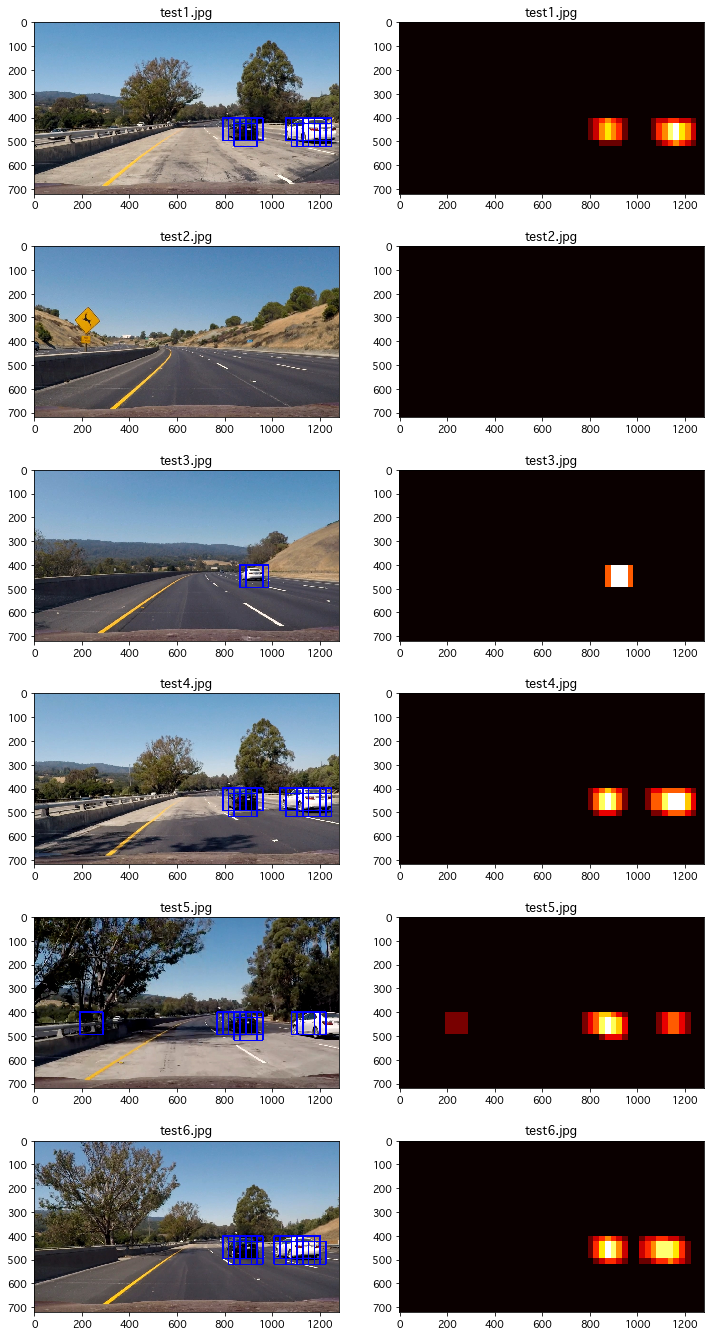

In [193]:
out_images = []
out_titles = []

# Consider a narrower swath in y
ystart = 400
ystop = 656
scale = 1.5

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_image, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, hist_bins)
                    
    out_images.append(draw_image)
    out_images.append(heatmap)
    out_titles.append(img_src.split('/')[-1])
    out_titles.append(img_src.split('/')[-1])
    titles.append(' ')
    print(time.time() - t1, 'seconds to run')

fig = plt.figure(figsize=(12, 24))
visualize(fig, 6, 2, out_images, out_titles)
plt.savefig('output_images/improved_sliding_windows.jpg', bbox_inches='tight')

## Section 7: Vehicle Detection with Label Box and Threshold

In [19]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

0.42417216300964355 seconds to run
0.395888090133667 seconds to run
0.37351298332214355 seconds to run
0.37921905517578125 seconds to run
0.3990180492401123 seconds to run
0.4660360813140869 seconds to run


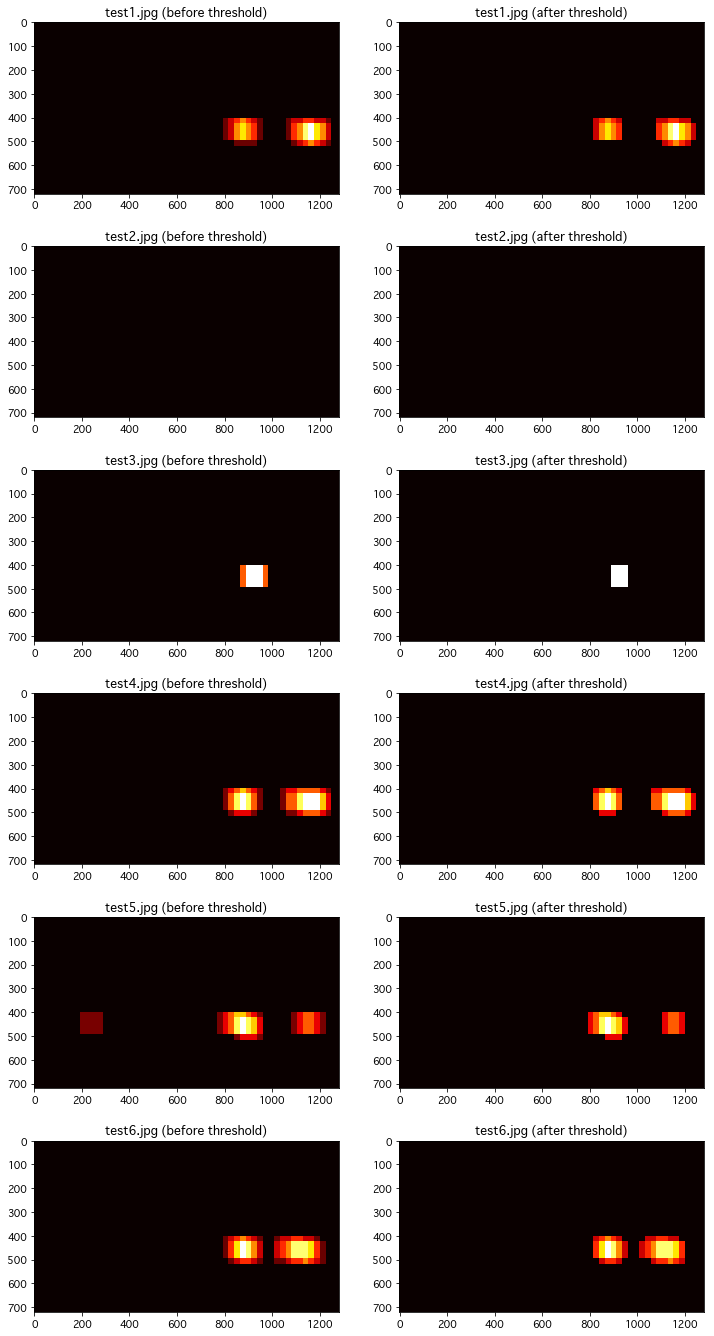

In [203]:
out_images = []
out_titles = []

# Consider a narrower swath in y
ystart = 400
ystop = 656
scale = 1.5
threshold = 1

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, hist_bins)
    # Apply threshold
    heatmap2 = apply_threshold(heatmap.copy(), threshold)
    #labels = label(heatmap)
    out_images.append(heatmap)
    out_images.append(heatmap2)
    out_titles.append(img_src.split('/')[-1] + ' (before threshold)')
    out_titles.append(img_src.split('/')[-1] + ' (after threshold)')
    print(time.time() - t1, 'seconds to run')

fig = plt.figure(figsize=(12, 24))
visualize(fig, 6, 2, out_images, out_titles)
plt.savefig('output_images/sliding_windows_with_threshold.jpg', bbox_inches='tight')

0.4511549472808838 seconds to run
0.4026150703430176 seconds to run
0.3704569339752197 seconds to run
0.38962793350219727 seconds to run
0.3864150047302246 seconds to run
0.38546204566955566 seconds to run


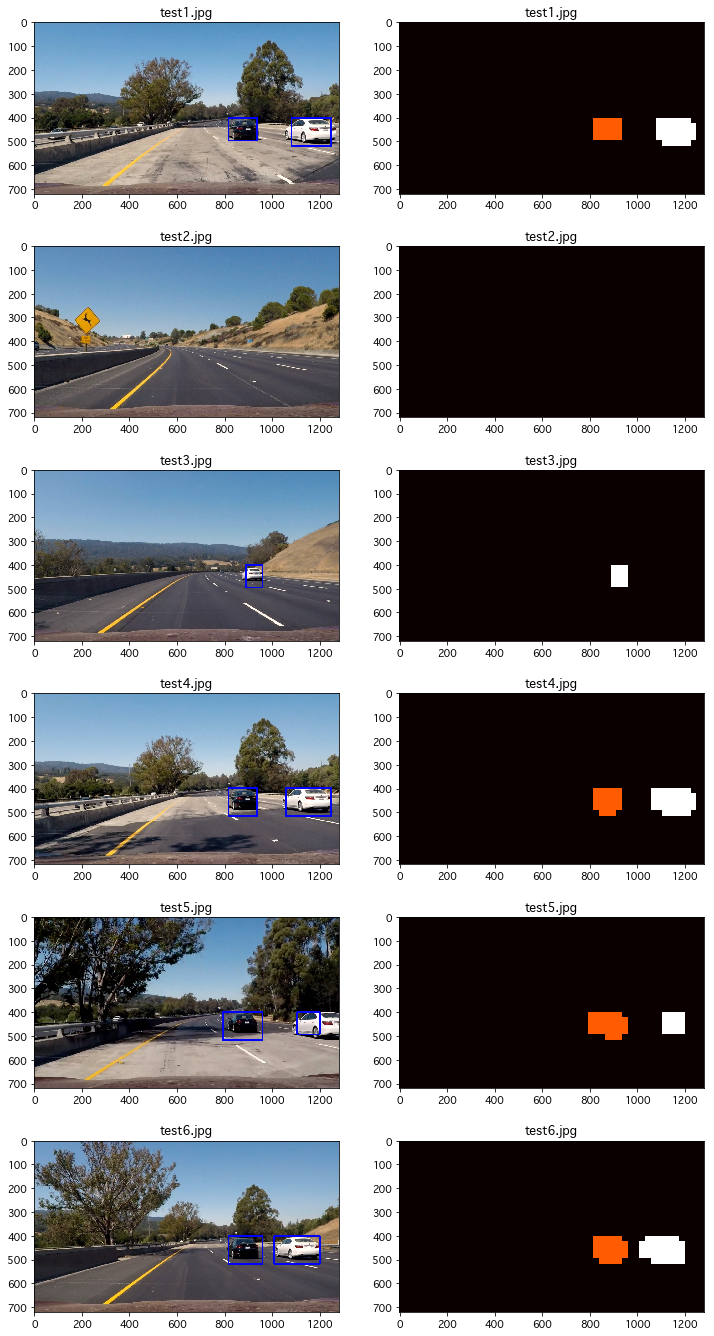

In [197]:
out_images = []
out_titles = []

# Consider a narrower swath in y
ystart = 400
ystop = 656
scale = 1.5
threshold = 1

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    out_image, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, hist_bins)
    # Apply threshold
    heatmap = apply_threshold(heatmap, threshold)
    labels = label(heatmap)
    # Draw bouding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    out_images.append(draw_img)
    out_images.append(labels[0])
    out_titles.append(img_src.split('/')[-1])
    out_titles.append(img_src.split('/')[-1])
    titles.append(' ')
    print(time.time() - t1, 'seconds to run')

fig = plt.figure(figsize=(12, 24))
visualize(fig, 6, 2, out_images, out_titles)
plt.savefig('output_images/sliding_windows_with_label_and_threshold.jpg', bbox_inches='tight')

## Section 8: Video Implemenation

In [21]:
class Tracker:
    # when starting a new instance please be sure to specify all unassigned
    # variables
    def __init__(self, mythreshold, mysmooth_factor):
        # list that stores the recent heatmap used for smoothing the output
        self.recent_heatmap = []
        self.threshold = mythreshold
        self.smooth_factor = mysmooth_factor

    # the main tracking function for finding and storing lane segment positions
    def find_cars_location(self, heatmap):
        self.recent_heatmap.append(heatmap)
        # return averaged values of heatmap from jumping around too much
        heatmap = np.average(self.recent_heatmap[-self.smooth_factor:], axis=0)
        heatmap = apply_threshold(heatmap, self.threshold)
        return heatmap

In [86]:
# Set up the overall class to do all the tracking
tracked_cars = Tracker(mythreshold=0.7, mysmooth_factor=20)

In [87]:
scale = 1.3
def process_image(img):
    out_image, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
                                 cell_per_block, spatial_size, hist_bins)
    heatmap = tracked_cars.find_cars_location(heatmap)
    labels = label(heatmap)
    
    # Draw bouding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [88]:
# Import everything needed to edit/savewatch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

test_output = 'output_video_20_07_scale13.mp4'
clip = VideoFileClip("project_video.mp4")
#clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_video_20_07_scale13.mp4
[MoviePy] Writing video output_video_20_07_scale13.mp4


100%|█████████▉| 1260/1261 [15:27<00:00,  1.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_20_07_scale13.mp4 



In [89]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))